In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import umap
import json
import time
import io
import re

In [2]:
# read the data in from csv
data = pd.read_csv('../data/reddit_dadjokes.csv', encoding='utf-8')

In [3]:
data.shape

(216328, 5)

In [4]:
data.head()

,author,url,joke,score,date
0,VERBERD,https://old.reddit.com/r/dadjokes/comments/rvz...,"Doctor: ""So, you're telling me that you have a...",1,2022-01-04 17:16:02
1,MHSPres,https://old.reddit.com/r/dadjokes/comments/rvz...,A grizzly kept talking to me and annoyed me He...,1,2022-01-04 17:14:44
2,craftworldyt,https://old.reddit.com/r/dadjokes/comments/rvz...,I rubbed mayonnaise on my eyes Oh fuck oh shit...,1,2022-01-04 16:57:58
3,dynam0,https://old.reddit.com/r/dadjokes/comments/rvy...,What do you say to encourage an asteroid? Go l...,1,2022-01-04 16:41:01
4,aAsm321,https://old.reddit.com/r/dadjokes/comments/rvy...,They always ask me why my mood is always negat...,1,2022-01-04 16:39:49


In [11]:
# filter data to score > 5 and jokes that don't contain "imgur"
curated = data[(data['score'] > 5) & (~data['joke'].str.contains("imgur"))]


In [12]:
curated.shape

(53133, 5)

In [14]:
curated.to_parquet("../../latent-scope/data/dadabase-curated/input.parquet")

In [5]:
# count rows with score greater than 1
rows_with_score_greater_than_1 = data[data['score'] > 1].shape[0]
rows_with_score_greater_than_1


87806

In [60]:
# np.savetxt("../data/reddit_dadjokes-text.csv", data["joke"].to_list(), delimiter=",", header="text", comments="", fmt='"%s"')
# export the joke column with the header "text" to a csv file
# data["text"] = data["joke"]
data["text"].to_csv("../data/reddit_dadjokes-text.csv", index=False, header=True, sep=',', quotechar='"', quoting=1, encoding='utf-8')


In [53]:
len(data["joke"].to_list())

216328

In [5]:
with open('../data/reddit_dadjokes-embeddings.json', 'r') as f:
    metadata = json.load(f)

In [13]:
with open('../data/reddit_dadjokes-embeddings.bin', 'rb') as f:
    embeddings = np.fromfile(f, dtype=np.float64)

In [14]:
#reshape the embeddings
embeddings = embeddings.reshape((len(metadata), metadata[0]["dimensions"]))

In [15]:
embeddings.shape

(216328, 1536)

In [23]:
# reduce dimensionality with umap
reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.075,
    metric='cosine',
    random_state=42,
    n_components=2,
    verbose=True,
)

In [24]:
umap_embeddings = reducer.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.075, n_neighbors=25, random_state=42, verbose=True)
Tue May  9 14:01:25 2023 Construct fuzzy simplicial set
Tue May  9 14:01:25 2023 Finding Nearest Neighbors
Tue May  9 14:01:25 2023 Building RP forest with 28 trees
Tue May  9 14:01:34 2023 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	 7  /  18
	Stopping threshold met -- exiting after 7 iterations
Tue May  9 14:02:00 2023 Finished Nearest Neighbor Search
Tue May  9 14:02:03 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue May  9 14:03:57 2023 Finished embedding


In [25]:
umap_embeddings.shape

(216328, 2)

/var/folders/sx/rrvr6l_d5x1_g46jxlx5ypfc0000gn/T/ipykernel_50614/1776845616.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=3, cmap='Spectral')


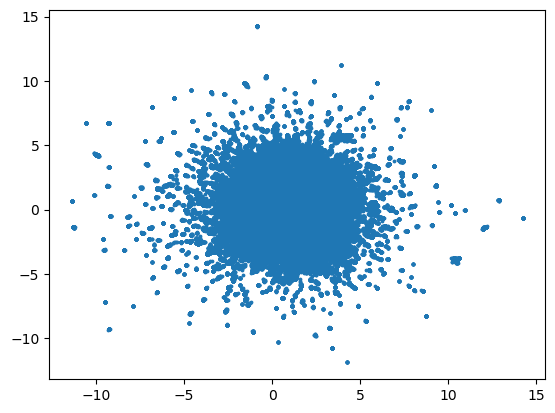

In [26]:
# plot embedding
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=3, cmap='Spectral')
plt.show()

In [27]:
#write embedding to csv file with header x,y
np.savetxt("../data/reddit_dadjokes-umap.csv", umap_embeddings, delimiter=",", header="x,y", comments='')

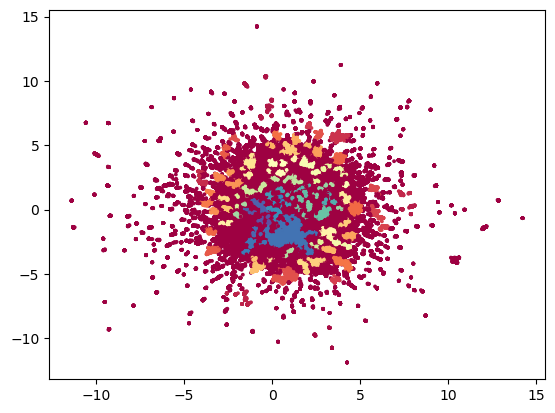

In [50]:
# Create an HDBSCAN instance with custom parameters
# cluster based on UMAP
clusterer = hdbscan.HDBSCAN(min_cluster_size=250, min_samples=200, metric='euclidean')
clusterer.fit(umap_embeddings)

cluster_labels = clusterer.labels_
np.unique(cluster_labels)
# plot embedding with cluster labels
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, s=3, cmap='Spectral')
# Find the centroids of the non-noise clusters
unique_labels = np.unique(cluster_labels)



In [51]:
unique_labels

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107])

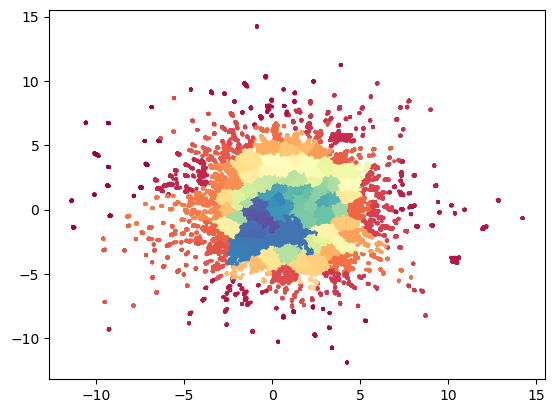

In [52]:
non_noise_labels = unique_labels[unique_labels != -1]
centroids = [umap_embeddings[cluster_labels == label].mean(axis=0) for label in non_noise_labels]
from scipy.spatial.distance import cdist
# Assign noise points to the closest cluster centroid
noise_points = umap_embeddings[cluster_labels == -1]
closest_centroid_indices = np.argmin(cdist(noise_points, centroids), axis=1)

# Update cluster_labels with the new assignments for noise points
noise_indices = np.where(cluster_labels == -1)[0]
new_assignments = [non_noise_labels[index] for index in closest_centroid_indices]
cluster_labels[noise_indices] = new_assignments
# plot embedding with cluster labels
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, s=3, cmap='Spectral')
# write clusterer.labels_ to a csv file

In [46]:
np.savetxt("../data/reddit_dadjokes-hdbscan.csv", clusterer.labels_, delimiter=",", header="cluster", comments="")


In [6]:
umap_embeddings_df = pd.read_csv("../data/reddit_dadjokes-umap.csv")
clusters_df = pd.read_csv("../data/reddit_dadjokes-hdbscan.csv")

In [8]:
df = data[['joke', 'score', 'author']].copy()
df['x'] = umap_embeddings_df['x']
df['y'] = umap_embeddings_df['y']
df['cluster'] = clusters_df['cluster']
df.head()


,joke,score,author,x,y,cluster
0,"Doctor: ""So, you're telling me that you have a...",1,VERBERD,-0.637819,-3.163073,79.0
1,A grizzly kept talking to me and annoyed me He...,1,MHSPres,0.915642,4.516339,50.0
2,I rubbed mayonnaise on my eyes Oh fuck oh shit...,1,craftworldyt,-4.260715,-0.290537,33.0
3,What do you say to encourage an asteroid? Go l...,1,dynam0,4.243083,-1.019731,39.0
4,They always ask me why my mood is always negat...,1,aAsm321,-2.101643,-3.925314,113.0


In [9]:
df.to_parquet("../data/reddit_dadjokes.parquet")

In [ ]:
# select all of the blog entries in the same order as the blog_entry_embeddings table
# data = data[["id", "text"]].copy()
# data.shape

In [16]:

# # add the cluster labels to the dataframe
# data['cluster'] = clusterer.labels_
# # add x and y as columns to the dataframe from the embedding
# data['x'] = umap_embeddings[:, 0]
# data['y'] = umap_embeddings[:, 1]
# data.head()
# # write the dataframe to a csv file
# data.to_csv("../data/akhaliq_tweets-processed.csv", index=False)
